In [110]:
import import_ipynb
from Functions import *

# Binary CNN

In [111]:
class BinCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BinCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Placeholder for the classifier; initialized later dynamically
        self.classifier = None
        self.num_classes = num_classes

    def initialize_classifier(self, input_shape):
        # Pass a dummy tensor to the features to get the output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
            feature_map = self.features(dummy_input)
            flattened_size = feature_map.numel()
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x):
        if self.classifier is None:
            self.initialize_classifier(x.shape[1:])  # Dynamically initialize based on input shape
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the feature map
        x = self.classifier(x)
        return Fun.softmax(torch.sum(x,dim=0))

# Main Model

In [112]:
class RegionCNN(nn.Module):
    def __init__(self, n: int):
        super(RegionCNN, self).__init__()
        
        # Convolutional layers with pooling and dropout
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # Output: (16, 300, 300)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # Output: (32, 300, 300)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                              # Output: (32, 150, 150)
        self.drop1 = nn.Dropout(p=0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Output: (64, 150, 150)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # Output: (128, 150, 150)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)                              # Output: (128, 75, 75)
        self.drop2 = nn.Dropout(p=0.25)
        
        # Adaptive pooling
        self.global_pool = nn.AdaptiveAvgPool2d((10, 5))  # Reduce spatial dimensions to (10, 5)

        # Fully connected layers
        self.flatten = nn.Flatten(0)
        self.l1 = nn.Linear(2*n*128 * 10 * 5, 500)
        self.drop3 = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(500, 25)
        
    def forward(self, x):
        x = Fun.relu(self.conv1(x))
        x = Fun.relu(self.conv2(x))
        x = self.pool1(x)  # Apply first pooling
        x = self.drop1(x)  # Apply dropout

        x = Fun.relu(self.conv3(x))
        x = Fun.relu(self.conv4(x))
        x = self.pool2(x)  # Apply second pooling
        x = self.drop2(x)  # Apply dropout

        x = self.global_pool(x)  # Adaptive pooling to (10, 5)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = Fun.relu(self.l1(x))
        #print(x.shape)
        x = self.drop3(x)  # Apply dropout
        #print(x.shape)
        x = self.l2(x)
        #print(x.shape)
        return x.view(5, 5)  # Reshape output to match the target shape

In [176]:
def Draw_BoundingBoxes(img,Boxes,Threshold=0.5):
    if torch.is_tensor(img):
        img = Frame2Numpy(Img).copy()
    X = img.shape[1]
    Y = img.shape[0]
    for i in range(len(Boxes)):
        if Boxes[i][4]>Threshold:
            x = int(Boxes[i][0]*X)
            y = int(Boxes[i][1]*Y)
            xl = int(Boxes[i][2]*X)
            yl = int(Boxes[i][3]*Y)
            img = cv2.rectangle(img,(x,y),(xl,yl),(0,255,0),2)
            #print(x,y,xl,yl,Boxes[i][4].item())
    return img

In [114]:
# Add content of box
def loss_function(Pred, Target, Img):
    X = Img.shape[2]
    Y = Img.shape[1]
    MinIndex = []
    criterion = nn.MSELoss()
    for v in range(len(Pred)):
        mv = float('inf')
        mi = 0
        for h in range(len(Target)):
            if h not in MinIndex:
                d = criterion(Pred[v][:-1],Target[h][:-1])
                if d < mv:
                    mv = d
                    mi = h
        MinIndex.append(mi)
    MinIndex = torch.tensor(MinIndex, dtype=torch.long)
    loss = 0
    for v in range(len(MinIndex)):
        dx = criterion((Pred[v][1]-Pred[v][3])**2,(Target[MinIndex[v]][1]-Target[MinIndex[v]][3])**2)
        dy = criterion(Pred[v][0]-Pred[v][2],Target[MinIndex[v]][0]-Target[MinIndex[v]][2])
        cx = criterion((Pred[v][1]+Pred[v][3])/2.0,(Target[MinIndex[v]][1]+Target[MinIndex[v]][3])/2)
        cy = criterion((Pred[v][0]+Pred[v][2])/2.0,(Target[MinIndex[v]][0]+Target[MinIndex[v]][2])/2)
        #if torch.all(Pred[v]>0) and torch.all(Pred[v]<1):
         #   pcontent = Img[:][int(Pred[v][0]*Y):int(Pred[v][2]*Y)][int(Pred[v][1]*X):int(Pred[v][3]*X)]
          #  tcontent = Img[:][int(Target[MinIndex[v]][0]*Y):int(Target[MinIndex[v]][2]*Y)][int(Target[MinIndex[v]][1]*X):int(Target[MinIndex[v]][3]*X)]
           # content = criterion(pcontent,tcontent)
        #else:
         #   content = 10
        loss += criterion(Pred[v][:4],Target[MinIndex[v]][:4])+criterion(Pred[v][-1],Target[MinIndex[v]][-1])+dx+dy+cx+cy#+content
    return loss

# Training Function

In [115]:
def train(Path, State=None, N=3, Batch=10, Epochs=10, LR=1e-4):
    Model = RegionCNN(N)
    Size = (300,300)
    
    if State is not None:
        Model.load_state_dict(States)
        Model.eval();
        
    Loss = []
    LMin = 1e20

    start_time = time.time()  # Start timer

    for epoch in range(Epochs):
        epoch_start_time = time.time()  # Timer for each epoch
        optimizer = optim.Adam(Model.parameters(), lr=LR)
        total_loss = 0.0

        for batch in range(Batch):
            optimizer.zero_grad()
            
            Frames = get_video_frames(Path, N, Size)
            Frames = torch.stack(Frames)
            
            Target = torch.zeros(5,5,dtype=torch.float)
            steps = random.randint(0,5)
            for s in range(steps):
                x,y,xl,yl = random.randint(0,3*Size[1]//4),random.randint(0,3*Size[0]//4),random.randint(10,Size[1]//5),random.randint(10,Size[1]//5)
                Target[s][0] = float(x/Size[1])
                Target[s][1] = float(y/Size[0])
                Target[s][2] = float((x+xl)/Size[1])
                Target[s][3] = float((y+yl)/Size[0])
                Target[s][4] = 1.0
                for p in range(N):
                    if random.random()>=0.5:
                        Frames[p] = AddOneInc1(Frames[p],x=x,y=y,xl=xl,yl=yl)
                Frames[N // 2] = AddOneInc1(Frames[N // 2],x=x,y=y,xl=xl,yl=yl)
                       
            # Pixel Differences 
            diff_pix = [Frames[i]-Frames[i+1] for i in range(len(Frames)-1)]
            diff_pix = torch.stack(diff_pix)
            #print(diff_pix.shape)
            
            # Edges Frames
            edge_frames = [Edges_tensor(Frames[i])-Edges_tensor(Frames[i+1]) for i in range(len(Frames)-1)]
            edge_frames = torch.stack(edge_frames)
            #print(edge_frames.shape)
            
            Scores = [TSSIM(Frames[i].unsqueeze(0),Frames[i+1].unsqueeze(0)) for i in range(len(Frames)-1)]
            Score = [t[0].item() for t in Scores]
            SimScores = [t[1].squeeze(0) for t in Scores]
            SimScores = torch.stack(SimScores)
            #print(SimScores.shape)
            
            All = torch.cat((diff_pix,edge_frames,SimScores),dim=0)
            #print(All.shape)
            
            # Forward pass
            Pred = Model(All)
            
            # Calculate loss
            loss = loss_function(Pred,Target,Frames[N//2])

            loss.backward()
            optimizer.step()
            

            total_loss += loss.item()
                        
            elapsed_time = time.time() - start_time
            avg_time_per_iter = elapsed_time / ((epoch * Batch) + batch + 1)
            remaining_iters = (Epochs * Batch) - ((epoch * Batch) + batch + 1)
            remaining_time = avg_time_per_iter * remaining_iters
            Mins = int(remaining_time//60)
            Secs = int(remaining_time%60)
            print(f'LR: {LR:0.4} Batch [{batch+1}/{Batch}], Loss: {loss.item():.4f} Time:{Mins}:{Secs:02}', end='\r')

            # Display predictions on the frame
            Img = Frames[N//2].unsqueeze(0)
            img = Draw_BoundingBoxes(Img,Pred,0.5)
            cv2.imshow("Prediction", img)
            cv2.waitKey(1)

        Loss.append(total_loss/Batch)
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / Batch:.6f}')
        
        LR *= 0.8
    
    States = Model.state_dict()
    
    cv2.destroyAllWindows()
    return Loss,States

# Training

In [116]:
cv2.destroyAllWindows()

In [117]:
State = None

In [118]:
# Add Unordered target boxes in loss

In [119]:
L,States = train('VDB',Batch=50,State=State,N=3,Epochs=10,LR=1e-5)

LR: 1e-05 Batch [50/50], Loss: 2.4078 Time:51:52
Epoch [1/10], Loss: 3.231855
LR: 8e-06 Batch [50/50], Loss: 0.9580 Time:54:10
Epoch [2/10], Loss: 2.444542
LR: 6.4e-06 Batch [50/50], Loss: 1.5721 Time:49:09
Epoch [3/10], Loss: 2.091382
LR: 5.12e-06 Batch [50/50], Loss: 1.8496 Time:48:19
Epoch [4/10], Loss: 2.234083
LR: 4.096e-06 Batch [50/50], Loss: 2.0342 Time:35:04
Epoch [5/10], Loss: 2.374458
LR: 3.277e-06 Batch [50/50], Loss: 2.5181 Time:24:53
Epoch [6/10], Loss: 2.273149
LR: 2.621e-06 Batch [50/50], Loss: 1.5717 Time:17:06
Epoch [7/10], Loss: 2.400728
LR: 2.097e-06 Batch [50/50], Loss: 2.0899 Time:10:31
Epoch [8/10], Loss: 2.272801
LR: 1.678e-06 Batch [50/50], Loss: 3.4783 Time:4:55
Epoch [9/10], Loss: 2.264990
LR: 1.342e-06 Batch [50/50], Loss: 2.0148 Time:0:00
Epoch [10/10], Loss: 2.243658


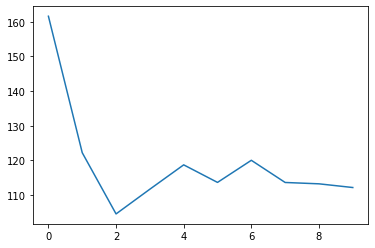

In [124]:
plt.plot(L) ##Cambios de Escenas

In [121]:
#torch.save(States,"StatesRID3N300x300.pth")

# Load and Predict

In [125]:
StatesR = torch.load("StatesRID3N300x300.pth")
StatesB = torch.load("StatesBID3N300x300.pth")

In [126]:
Size = (300,300)
N = 3
Model = BinCNN(2)
dummy = torch.rand((N-1)*3,3,Size[0],Size[1])
Model(dummy)
Model.load_state_dict(StatesB)
Model.eval();

In [191]:
RIDModel = RegionCNN(3)
RIDModel.load_state_dict(StatesR)
RIDModel.eval();

# Predict

In [217]:
Frames = get_video_frames("AI Gen",N,(300,300))
diff_pix = [Frames[i]-Frames[i+1] for i in range(len(Frames)-1)]
diff_pix = torch.stack(diff_pix)
edge_frames = [Edges_tensor(Frames[i])-Edges_tensor(Frames[i+1]) for i in range(len(Frames)-1)]
edge_frames = torch.stack(edge_frames)
Scores = [TSSIM(Frames[i].unsqueeze(0),Frames[i+1].unsqueeze(0)) for i in range(len(Frames)-1)]
Score = [t[0].item() for t in Scores]
SimScores = [t[1].squeeze(0) for t in Scores]
SimScores = torch.stack(SimScores)
All = torch.cat((diff_pix,edge_frames,SimScores),dim=0)

In [218]:
Pred = Model(All)
print(f'Probability of Inconsistency: {Pred[0].item():.4f}')
print(f'Prediction: {round(Pred[0].item())}')

Probability of Inconsistency: 0.4114
Prediction: 0


In [212]:
Frames_Np = [cv2.cvtColor(Frames[n].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB) for n in range(len(Frames))]

In [213]:
ThroughFrames(Frames_Np)

In [214]:
Coord = RIDModel(All)

In [215]:
Frames_Np[N//2] = Draw_BoundingBoxes(Frames_Np[N//2],Coord,0.5)

In [216]:
ThroughFrames(Frames_Np)

In [122]:
#Que hace el mecanismo de atencion en procesamiento de imagenes
#Sino en PLN
#Embeding/Classes
#Cambios de Escenas con escena anterior (COnsecutivo)

In [123]:
# Autoencoders y comparacion